# Classicação do CIFAR-10 usando Redes Neurais Convolucionais

Esse notebook discute mais a respeito das *Convolutional Neural Network* (CNN) explicando um pouco sobre seu embasamento teórico e sua implementação utilizando ```keras``` em ```tensorflow 2.0```.

Portanto, este documento tem o intuito de apresentar uma introdução no idioma português, que carece de materiais desse tipo.

**Objetivo**

Desenvolver uma CNN acoplada a uma DNN (Dense Neural Network) para prever corretamente as classes do banco de dados CIFAR-10.

**Arquitetura**
![arc](https://user-images.githubusercontent.com/32513366/71742171-a1c3c300-2e3f-11ea-9066-56ce1b243888.png)

A mesma ideia será aplicada para este classificador: uma **CNN** será responsável por encontrar (automaticamente) os atributos (*features*) e uma **DNN** irá utiliza-los para classificar aquela imagem em uma das categorias.

## Módulos utilizados

In [60]:
# Biblioteca básica do python
import numpy as np
# Para o desenvolvimento dos modelos de Deep Learning
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import datasets, models, layers, optimizers

# Para tuning de modelo
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Para fazer alguns gráficos caso necessário
import matplotlib.pyplot as plt
import seaborn as sns
import keras

In [2]:
# Comandos para notebook
%matplotlib inline

## CIFAR-10
Ao total, esse banco de dados contém 60,000 imagens com 10 classes diferentes e bem balanceadas (em média 6,000 imagens por classe). As classes são:
- airplane (avião)
- automobile (carro)
- bird (passaro)
- cat (gato)
- deer (veado)
- dog (cachorro)
- frog (sapo)
- horse (cavalo)
- ship (navio)
- truck (caminhão)

Cada imagem ,ou tensor, possui a seguinte dimensão: **32 X 32 X 3** que respectivamente se trata da: altura, largura e canais RGB. 
Cada *label* apresenta um valor de 0 a 9, representando respectivamente a classe daquela imagem.

In [3]:
# Importando banco de dados
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data();

In [4]:
# Normalizando os valores dos pixels para o intervalo de 0 a 1
train_images, test_images = train_images/255.0, test_images/255.0

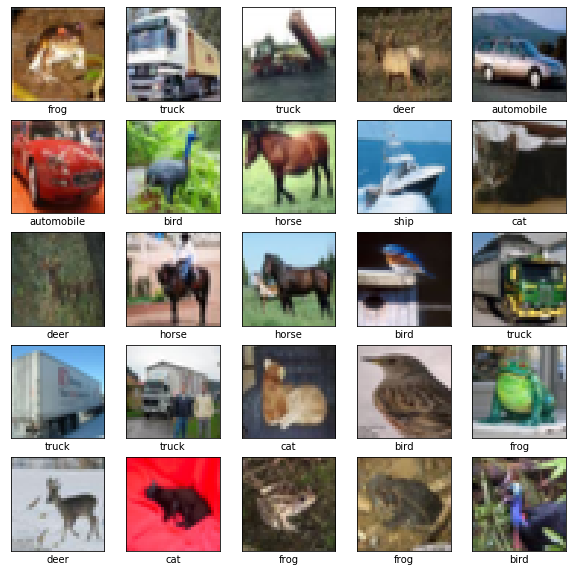

In [5]:
# Definindo as classes
class_names = ['airplane','automobile','bird','cat', 'deer','dog','frog','horse','ship','truck']

# Analisando algumas imagens do CIFAR
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

In [ ]:
# Para este notebook irei juntar ambos os conjuntos train/test (por causa do otimizador talos)
x = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

# Parte 1: Criando a Rede de Convolução (CNN)

As redes convolucionais podem ser divididas em dois tipos de camadas principais que juntas são responsáveis por extrair atributos capazes de auxiliar na classicação. São elas a convolução e *max pooling*.

A convolução, representada no ```keras``` pela função ```Conv2D```, é responsável pela aplicação de um filtro sobre a imagem e esta é a primeira etapa na coleta de atributos. Trata-se de uma operação linear de multiplicação de matrizes elemento a elemento (*element-wise*) entre o filtro e a imagem (uma parte da imagem de cada vez).

![conv)](https://user-images.githubusercontent.com/32513366/71742393-670e5a80-2e40-11ea-9f6d-262e3eedc122.gif)

Baseado no exemplo acima, você pode ver o filtro (chamado comumente de *filter* ou *kernel*) em amarelo e a imagem em verde. O processo segue as etapas:
- Filtro passa sobre uma parcela da imagem
- Ocorre a operação *element-wise*: **kernel ∘ parcela da imagem**
- A matriz resultante dessa operação é somada para um valor escalar
- Filtro se move e repete o processo até acabar a imagem

Ao final desse processo de convolução é gerado um *convoluted feature* que irá conter informações da imagem de forma mais condensada.

O *Max Pooling*, representado no ```keras``` pela função ```MaxPool2D```, é uma fase mais simples e atua em cima de cada *convoluted feature* (lembre-se que cada filtro gera o seu respectivo) após o processo de convolução. Seu objetivo maior é diminuir a dimensionalidade daquela saída, diminuindo assim o custo computacional através da redução de parâmetros para serem treinados. Abaixo temos um exemplo de como é feito em si o *Max Pooling*:

![MP](https://user-images.githubusercontent.com/32513366/71745384-b6f11f80-2e48-11ea-93a8-5791b29861e3.png)

O processo é feito da seguinte maneira: é escolhido apenas o **maior** valor de cada região para compor a nova saída, que agora apresenta uma redução de dimensões (altura e largura).

Todavia, a implementação de todo esse processo não é trivial e requer do operador a definição de alguns parâmetros que **não podem ser aprendidos pela rede** (forma geral apenas aprende os pesos/bias). Eu irei apresenta-los em termos de código, seguindo como padrão a aplicação em ```keras``` desenvolvida abaixo:
- ```filters```: quantidade de filtros que serão utilizados para fazer o processo de convolução em cada entrada.
- ```kernel_size```: tamanho do filtro dado em (altura, largura) para o processo de convolução.
- ```strides```: tamanho do passo que o filtro irá dar para se movimentar horizontalmente e verticalmente sobre a imagem. No exemplo anterior para convolução, seu valor é 1 passo horizontal e 1 passo vertical. Já para o *max pool*, seu valor é de 2 passos horizontais e 2 passos verticais (vale ressaltar que no processo de *max pool* é incomum ocorrer regiões com intersecção).
- ```padding```: trata-se da inserção de bordas na imagem (com valor zero). Essa opção permite que atributos mais próximos das laterais da imagem sejam tão relevalentes quanto os atributos mais centrais. Além disso, a não utilização dessa opção permite uma redução de dimensionalidade natural durante o processo de convolução. Abaixo segue exemplificações visuais para facilitar o entendimento.
    - Com padding (opção *same*)
    ![same_padding_no_strides](https://user-images.githubusercontent.com/32513366/71746263-37b11b00-2e4b-11ea-9ad9-d76cbc3da544.gif)
    - Sem padding (opção *valid*)
    ![no_padding_no_strides](https://user-images.githubusercontent.com/32513366/71746267-38e24800-2e4b-11ea-92e9-72d25a5b7d3e.gif)

- ```pool_size```: tamanho do filtro para ser aplicado o processo de *max pooling*.

Além dessas existem diversos parâmetros que precisam ser definidos antes do treinamento do modelo como a quantidade de camadas, função de ativição, forma de inicialização de pesos e etc. Todavia, os parâmetros listados anteriormente são característicos deste tipo de modelo (CNN).

## CNN - Arquitetura proposta
O modelo proposto consiste em uma arquitetura clásssica que aqui será chamada de *bloco extrator de características*:
- Convolutional 2D com filtro 3x3, stride unitário e padding 'same'
- Batch Normalization
- Ativação ReLU
- Convolutional 2D com filtro 3x3, stride unitário e padding 'same'
- Batch Normalization
- Ativação ReLU
- Max Pooling 2D

Para evitar overfit do modelo, irei adicionar camadas *Dropout* após cada Max Pooling!

Essa sequência é bastante utilizada em outras tarefas como segmentação de imagens e aqui ela será repetida **3 vezes**. Ao final será inserido as camadas totalmente conectadas para fazer a predição.

In [15]:
# Definindo os dimensões de entrada para o modelo
image_shape = (32,32,3)

# Declarando objeto
cnn = models.Sequential()
# Definindo o primeiro bloco extrator, note que aqui o formato da imagem é aplicado
cnn.add(layers.Conv2D(filters=32,kernel_size=(3,3), strides=(1,1),padding='same',input_shape=image_shape))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1), padding='same'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
cnn.add(layers.Dropout(rate=0.25))
# Definindo o segundo bloco extrator
cnn.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding='same'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1), padding='same'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
cnn.add(layers.Dropout(rate=0.25))
# Definindo o terceiro bloco extrator
cnn.add(layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='same'))
cnn.add(layers.BatchNormalization())
cnn.add(layers.Activation('relu'))
cnn.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
cnn.add(layers.Dropout(rate=0.25))

In [16]:
# Sumário do modelo
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

# Parte 2: Criando a Rede de Toda-Conectada (DNN)

Trata-se de uma das arquitetura iniciais que surgiram no estudo de *Deep Learning*. Seu modelo consiste em todos os neurônios conectados entre si até o final:
![dnn](https://user-images.githubusercontent.com/32513366/71747029-59ab9d00-2e4d-11ea-91d8-2aa03516f9cd.png)

Sua explicação não faz parte do escopo deste notebook, mas de forma geral seu parâmetro principal (além da profundidade do modelo, isto é, quantidade de camadas) que precisa ser definido é:
- ```units```: quantidades de neurônios presentes naquela camada

Todavia, para conectar a CNN que apresenta uma resposta n-dimensional (4x4x128) em um modelo que precisa de uma entrada vetorial é necessário inserir uma camada extra: ```Flatten```. Essa camada será responsável por tornar a resposta da CNN em uma resposta vetorial de dimensão: (*N*x1) Onde *N* é dado pela multiplicação das dimensões da saída anterior, portanto *N* = 2048.

O modelo de DNN é dado por apenas um camada totalmente conectada a saída.

In [17]:
# Flatten N-D Vetor em 1-D Vetor
cnn.add(layers.Flatten())
# Primeira camada para DNN
cnn.add(layers.Dense(units = 128,activation='relu',name='dense_1',kernel_initializer='he_normal'))
# Saída
cnn.add(layers.Dense(units = 10,activation='softmax',kernel_initializer='he_normal',name='dense_output'))

In [18]:
# Avalie a arquitetura geral desenvolvida
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

# Parte 3: Compilando o modelo

Nesta etapa, a arquitetura desenvolvida será compilada indicando de forma geral como será feito o aprendizado deste modelo. Será nessa etapa que será definido o ```optmizer``` (método de otimização para ser usado no treinamento), ```loss``` (função a ser otimizada) e ```metrics``` (cálculo para ser utilizado na verificação da qualidade do modelo).

In [19]:
cnn.compile(optimizer='Adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

# Parte 4: Treinando o modelo
Nesta etapa, o modelo será treinado/validado utilizando apenas o banco de dados *train* para utilizar o *test* na validação final. Aqui é definido principalmente ```epochs```(quantidade de vezes que o modelo irá treinar sobre todo o banco de dados de treino) e ```batch_size``` (tamanho necessário de amostras para atualizar a quantidade de pesos).

O modelo será treinado fazendo um *split* de 20% no banco de dados para validação.

Depois, o modelo será avaliado em um conjunto inédito: o conjunto de teste.

In [20]:
cnn_training = cnn.fit(x = train_images,
                       y = train_labels,
                       epochs = 15,
                       batch_size=32,
                       validation_split=0.2,
                       verbose=2)               

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
40000/40000 - 164s - loss: 1.4289 - accuracy: 0.4792 - val_loss: 1.2082 - val_accuracy: 0.5670
Epoch 2/15
40000/40000 - 167s - loss: 0.9705 - accuracy: 0.6544 - val_loss: 0.9366 - val_accuracy: 0.6694
Epoch 3/15
40000/40000 - 170s - loss: 0.8113 - accuracy: 0.7117 - val_loss: 0.7684 - val_accuracy: 0.7270
Epoch 4/15
40000/40000 - 169s - loss: 0.7147 - accuracy: 0.7496 - val_loss: 0.7995 - val_accuracy: 0.7142
Epoch 5/15
40000/40000 - 179s - loss: 0.6486 - accuracy: 0.7723 - val_loss: 0.8229 - val_accuracy: 0.7248
Epoch 6/15
40000/40000 - 204s - loss: 0.5923 - accuracy: 0.7944 - val_loss: 0.7523 - val_accuracy: 0.7495
Epoch 7/15
40000/40000 - 209s - loss: 0.5469 - accuracy: 0.8080 - val_loss: 0.7908 - val_accuracy: 0.7355
Epoch 8/15
40000/40000 - 203s - loss: 0.5023 - accuracy: 0.8237 - val_loss: 0.6042 - val_accuracy: 0.7909
Epoch 9/15
40000/40000 - 200s - loss: 0.4684 - accuracy: 0.8369 - val_loss: 0.5726 - val_accuracy: 0.8

Ao final da última *epoch* nossa arquitetura conseguiu uma acurácia de validação: **~82%** .

## Avaliando a performance durante o treinamento do modelo

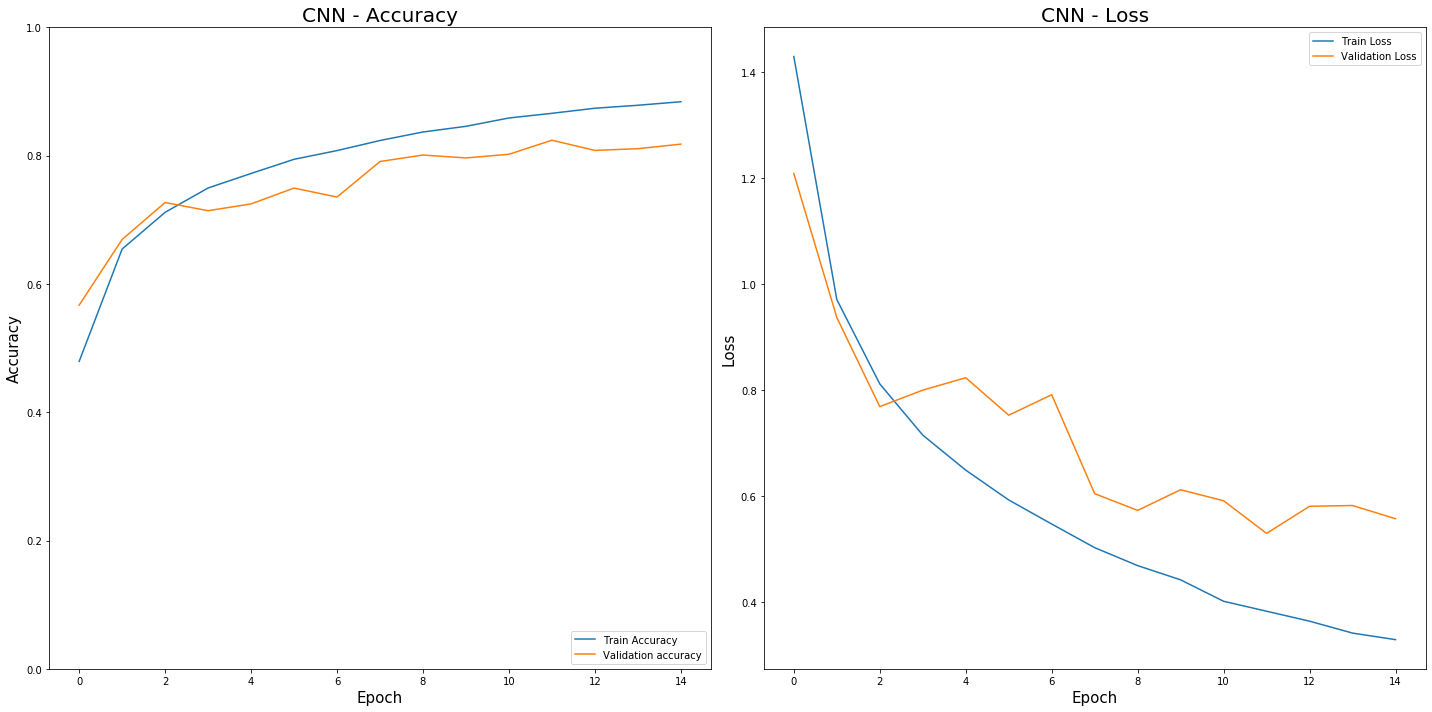

In [23]:
# Plots
fig, ax = plt.subplots(1,2, figsize=(20,10));
# Accuracy X Epochs
ax[0].plot(cnn_training.history['accuracy'], label='Train Accuracy')
ax[0].plot(cnn_training.history['val_accuracy'], label = 'Validation accuracy')
ax[0].set_title('CNN - Accuracy', fontsize=20)
ax[0].set_xlabel('Epoch', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_ylim([0, 1])
ax[0].legend(loc='lower right')
# MSE X Epochs
ax[1].plot(cnn_training.history['loss'], label='Train Loss')
ax[1].plot(cnn_training.history['val_loss'], label = 'Validation Loss')
ax[1].set_title('CNN - Loss', fontsize=20)
ax[1].set_xlabel('Epoch', fontsize=15)
ax[1].set_ylabel('Loss', fontsize=15)
ax[1].legend(loc='upper right', fontsize=10)

# Default to improve spaces between the plots
plt.tight_layout()

# Parte 5: Avaliando a predição em um conjunto inédito

## Acurácia no conjunto de teste

In [30]:
# Predicao no conjunto de teste
cnn_predict = cnn.predict(x=test_images)

In [38]:
# Quantos o modelo acertou?
correct_preds = 0
for true, pred in zip(test_labels, cnn_predict):
    if np.argmax(pred) == true:
        correct_preds += 1

In [71]:
# Mostrar resultado
print('O modelo acertou ', correct_preds,' imagens de ',len(test_labels),
      ' imagens no conjunto teste. Acurácia de acerto é de ',
      round(100*correct_preds/len(test_labels), 2), '%.')

O modelo acertou  8129  imagens de  10000  imagens no conjunto teste. Acurácia de acerto é de  81.29 %.


## Probabilidade para as classes

A utilização da ativação `softmax` na última camada permite visualizarmos a probabilidade que o modelo deu para qualquer novo caso:

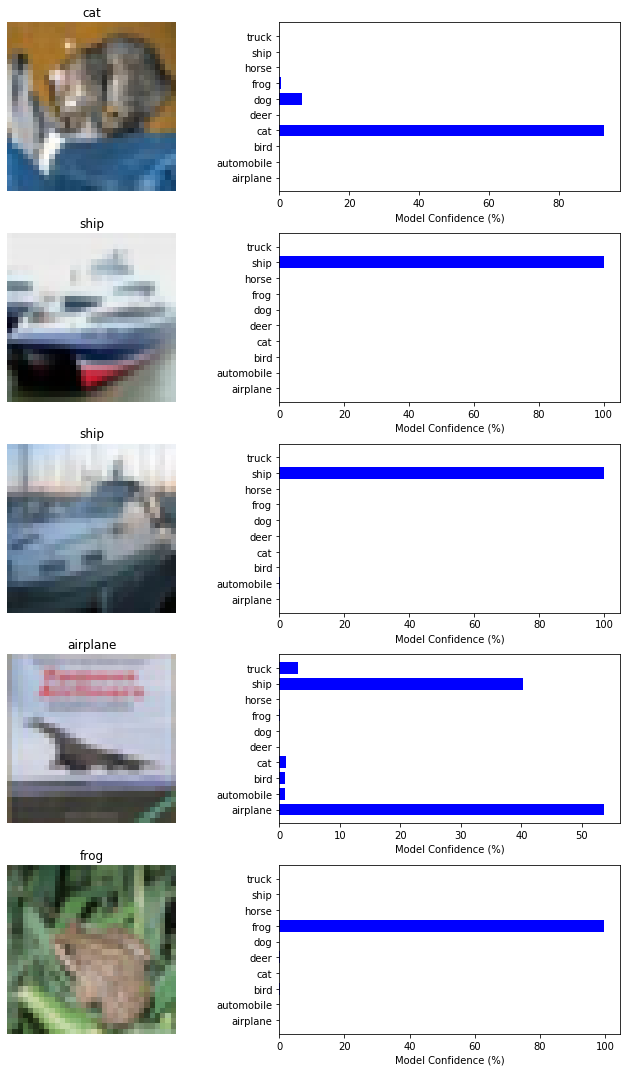

In [59]:
# Definir quantidade de imagens para apresentar
n_samples = 5
# Loop para fazer o plot
fig, axes = plt.subplots(nrows=n_samples, ncols=2, figsize=(10,15))
for test_img, test_lbl, prob, i in zip(test_images, test_labels, cnn_predict, range(n_samples)):
    # Plot image
    axes[i][0].imshow(test_img, cmap=plt.cm.binary)
    axes[i][0].axis('off')
    axes[i][0].set_title(class_names[test_lbl[0]])
    # Plot barplot
    axes[i][1].barh(class_names, prob*100, 0.75, color='blue')
    axes[i][1].set_xlabel('Model Confidence (%)')
plt.tight_layout()    

# Parte 6: Melhorando o modelo

Dado a imensa quantidade de hiper-parâmetros que precisamos definir desde a quantidade de camadas até funções de ativação, perguntas como: "Qual a melhor combinação para alcançar a melhor acurácia?" são bem recorrentes.
Todavia, testar todas as possibilidades apresenta alguns problemas:
- a quantidade de combinações cresce exponencialmente
- pode ser tedioso criar manualmente cada combinação

Todavia existe uma extensão do Keras chamada `keras.tuner` que de forma simples e eficaz, permite a análise de diferentes combinações de parâmetros. Vale ressaltar que existem outras opções de solucionar esse problema como:
- AutoML Zero
- Talos (funciona de forma semelhante ao tuner do `keras`)

Dado ao custo computacional decorrente da tentativa de avaliar N combinações, irei apenas avaliar a seguinte questão:

**Aumentar ou diminuir a quantidade de blocos extrator de características  e camadas DNN permite um aumento de acurácia?**

Vale ressaltar que, a arquitetura criada anteriormente apresentava um aumento na quantidade de filtros a medida que as camadas ficavam mais internas começando de 16 e seguindo para 32, 64 e etc. Para este experimento, também será feito isso tanto para CNN quanto para DNN (no caso, quantidade de neurônios).

Os passos para utilizar a funcionalidade da biblioteca `keras.tuner` são:
- criar função para criação do modelo e com seu retorno compilado. Esta função precisa receber o argumento referente ao hiper-parâmetro
- Fazer a busca

**OBS**: Será utilizado aqui o algoritmo *Random Search* que como o próprio nome diz faz uma busca aleatória no espaço de hiper-parâmetros possíveis.

In [81]:
# Função - Criar modelo a partir dos hiper parâmetros
def build_cnn_model(hp):
    # Definir um conjunto fixado de hiper-parâmetros (necessita manter a ordem crescente e nao aleatoria)
    n_filters = [32,64,128]
    n_units = [64,128,256]
    # Inicia o modelo normalmente
    CNN = models.Sequential()
    # Criar o bloco inicial, pois contém o formato da entrada
    CNN.add(layers.Conv2D(filters=16,kernel_size=(3,3), strides=(1,1),padding='same',input_shape=image_shape))
    CNN.add(layers.BatchNormalization())
    CNN.add(layers.Activation('relu'))
    CNN.add(layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1,1), padding='same'))
    CNN.add(layers.BatchNormalization())
    CNN.add(layers.Activation('relu'))
    CNN.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
    CNN.add(layers.Dropout(rate=0.25))
    # Primeiro Loop - Quantos blocos extratores serao usados
    for BLOCKS, filters_dim in zip(range(hp.Int('conv_blocks_quantity', 1, 3, step=1)), n_filters):
        CNN.add(layers.Conv2D(filters=filters_dim,kernel_size=(3,3), strides=(1,1),padding='same'))
        CNN.add(layers.BatchNormalization())
        CNN.add(layers.Activation('relu'))
        CNN.add(layers.Conv2D(filters=filters_dim,kernel_size=(3,3),strides=(1,1), padding='same'))
        CNN.add(layers.BatchNormalization())
        CNN.add(layers.Activation('relu'))
        CNN.add(layers.MaxPool2D(pool_size=(2,2),strides=2))
        CNN.add(layers.Dropout(rate=0.25))
    # Adiciona a camada auxiliar Flatten
    CNN.add(layers.Flatten())
    # Segundo Loop - Quantas camadas de DNN para inserir
    for DENSE_LAYERS, units_dim in zip(range(hp.Int('dnn_layers_quantity', 1, 3,step=1)), n_units):
        CNN.add(layers.Dense(units = units_dim,activation='relu'))
        CNN.add(layers.Dropout(rate=0.25))
    # Adiconar camada de saida
    CNN.add(layers.Dense(units=10,activation='softmax'))
    # Compilar modelo
    CNN.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    # Retornar modelo
    return CNN

In [82]:
# Definir um local para salvar os resultados da busca
LOG_DIR = 'cnn_model_cifar_tuner_keras'

In [83]:
# Definir o objeto do tuner
tuner = RandomSearch(build_cnn_model,
                     objective='val_accuracy',
                     max_trials=3,
                     executions_per_trial=2,
                     directory=LOG_DIR
                    )

In [84]:
# Verificar espaço de busca
tuner.search_space_summary()

Antes de continuar, é necessário explicar alguns argumentos do objeto para tuning:
- `objective`: métrica que irá definir o melhor modelo
- `max_trials`: Considerando a RandomSearch utilizada, quantas combinações diferentes serão avaliadas
- `executions_per_trial`: Quantas vezes você irá avaliar treinar aquela mesma combinação. Aumentar este valor pode acarretar em melhoras de 1 ou 2% na acurácia final do mesmo modelo

In [85]:
# Processo de busca de hiper-parâmetros
tuner.search(x=train_images,
             y=train_labels,
             epochs=15,
             batch_size=32,
             verbose=0,
             validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [86]:
# Resultado geral
tuner.results_summary()

## Observações
Vale ressaltar que a forma implementada aqui possui um cunho **didático** para garantir uma maior agilidade do processo de busca de hiper-parâmetros:
- É recomendado um `executions_per_trial` maior que 1, isso pode trazer uma melhora de 1-2% no resultado do melhor modelo
- Quanto maior `max_trials`, mais chances de encontrar um modelo melhor
- Note que meu valor para `epochs` foi menor do que o original. Isso foi feito para aumentar a rapidez do processo dado a quantidade modelos diferentes que serão analisados.

Logo ao comparar os resultados encontrados aqui com o modelo original é necessário compreender essas prerrogativas. O correto é manter o processo de treinamento/validação/teste o mais próximo possível para comparar os resultados.

## Qual foi a melhor combinação de parâmetros?

In [87]:
# Melhor modelo
best_model = tuner.get_best_models(num_models=1)

Aparentemente através desta pequena busca não foi possível encontrar um modelo superior ao original visto que a melhor combinação apresenta uma acurácia de **78%**.

# Parte 7:  Conclusão
Através deste notebook foi possível entender um pouco mais sobre conceitos de:
- Redes convolucionais e suas características
- Redes totalmente conectadas
- Como aplicar uma otimização de hyper parâmetros

Ao final foi apresentado um modelo com uma acurácia em torno de **82%** de predição.

# Referências
Os materiais utilizados como base para este documento se encontram abaixo (na língua inglesa):
- [Keras conv2D and Convolutional layers from pyimagesearch](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
- [tensorflow 2.0 tutorials for CNN](https://www.tensorflow.org/tutorials/images/cnn)
- [keras docs for convolucional layers](https://keras.io/layers/convolutional/)
- [theano tutorial for CNN arithmetics](http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html)
- [Beginners guide to CNN from TDS](https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8)
- [ELI5 way for CNN from TDS](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [Beginners guide to CNN from Adit Deshpande blog](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)
- [Optimizing Neural Network Structures with Keras-Tuner](https://www.youtube.com/watch?v=vvC15l4CY1Q)
- [Hyperparameter tuning with Keras Tuner](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)